In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from models import RealNVP, build_ff_model, ConditionalCouplingLayer
import warnings
warnings.filterwarnings("ignore")  

data_path = "../data/"  


# Load the dataset
df = pd.read_csv(f"{data_path}insurance.csv")


# One-hot encode categorical features
t_sex    = torch.tensor(pd.get_dummies(df["sex"]).values, dtype=torch.float32)
t_smoker = torch.tensor(pd.get_dummies(df["smoker"]).values, dtype=torch.float32)
t_region = torch.tensor(pd.get_dummies(df["region"]).values, dtype=torch.float32)

# Scale numeric features and target
t_age      = torch.tensor(df["age"].values, dtype=torch.float32).unsqueeze(1) / 100.0
t_bmi      = torch.tensor(df["bmi"].values, dtype=torch.float32).unsqueeze(1) / 100.0
t_children = torch.tensor(df["children"].values, dtype=torch.float32).unsqueeze(1) / 10.0
t_charges  = torch.tensor(df["charges"].values, dtype=torch.float32).unsqueeze(1) / 50000.0

# Concatenate all input features into one tensor (shape: [N, 11])
t_input = torch.cat([t_age, t_bmi, t_children, t_sex, t_smoker, t_region], dim=1)


In [3]:


#############################################
# k-Fold Cross-Validation Evaluation
#############################################

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store average metrics for each fold
ff_fold_mse   = []  # Feed-forward test MSE
flow_fold_mse = []  # Flow (mean prediction) test MSE
flow_fold_nll = []  # Flow test negative log-likelihood

epochs_cv = 100
lr_cv     = 0.01
loss_fn   = nn.MSELoss()

fold_no = 1
for train_index, test_index in kf.split(t_input):
    print(f"\n--- Fold {fold_no} ---")
    # Prepare splits for this fold
    X_train_cv = t_input[train_index]
    y_train_cv = t_charges[train_index]
    X_test_cv  = t_input[test_index]
    y_test_cv  = t_charges[test_index]
    
    # Train Feed-Forward Model
    ff_model_cv = build_ff_model()
    optimizer_ff_cv = optim.Adam(ff_model_cv.parameters(), lr=lr_cv)
    for epoch in range(epochs_cv):
        ff_model_cv.train()
        optimizer_ff_cv.zero_grad()
        y_pred_cv = ff_model_cv(X_train_cv)
        loss_cv = loss_fn(y_pred_cv, y_train_cv)
        loss_cv.backward()
        optimizer_ff_cv.step()
    
    ff_model_cv.eval()
    with torch.no_grad():
        y_pred_test_cv = ff_model_cv(X_test_cv)
    # Un-scale predictions/targets
    y_pred_test_cv_unscaled = y_pred_test_cv * 50000.0
    y_test_cv_unscaled      = y_test_cv * 50000.0
    mse_ff_cv = torch.mean((y_pred_test_cv_unscaled - y_test_cv_unscaled)**2)
    ff_fold_mse.append(mse_ff_cv.item())
    print(f"Feed-Forward Test MSE: {mse_ff_cv.item():.2f}")
    
    # Train Normalizing Flow Model
    flow_model_cv = RealNVP(x_dim=11, hidden_dim=64, num_flows=2)
    optimizer_flow_cv = optim.Adam(flow_model_cv.parameters(), lr=lr_cv)
    for epoch in range(epochs_cv):
        flow_model_cv.train()
        optimizer_flow_cv.zero_grad()
        log_prob_cv = flow_model_cv.log_prob(y_train_cv, X_train_cv)
        loss_flow_cv = -log_prob_cv.mean()
        loss_flow_cv.backward()
        optimizer_flow_cv.step()
    
    flow_model_cv.eval()
    with torch.no_grad():
        log_prob_test_cv = flow_model_cv.log_prob(y_test_cv, X_test_cv)
    nll_flow_cv = -log_prob_test_cv.mean().item()
    flow_fold_nll.append(nll_flow_cv)
    print(f"Flow Test NLL: {nll_flow_cv:.4f}")
    
    # Estimate Flow Mean Predictions and compute MSE
    num_samples_cv = 100  # samples per test instance
    flow_preds_cv = []
    for i in range(X_test_cv.shape[0]):
        x_i_cv = X_test_cv[i].unsqueeze(0)  # [1, 11]
        z_samples_cv = torch.randn(num_samples_cv, 1)
        x_repeated_cv = x_i_cv.repeat(num_samples_cv, 1)
        with torch.no_grad():
            y_samples_cv = flow_model_cv.inverse(z_samples_cv.squeeze(-1), x_repeated_cv)
        flow_preds_cv.append(y_samples_cv.mean().item())
    flow_preds_cv = torch.tensor(flow_preds_cv, dtype=torch.float32)
    flow_preds_cv_unscaled = flow_preds_cv * 50000.0
    mse_flow_cv = torch.mean((flow_preds_cv_unscaled - y_test_cv_unscaled.squeeze())**2)
    flow_fold_mse.append(mse_flow_cv.item())
    print(f"Flow Mean Prediction Test MSE: {mse_flow_cv.item():.2f}")
    
    fold_no += 1

print("\n=== k-Fold Cross-Validation Results ===")
print(f"Average Feed-Forward Test MSE: {np.mean(ff_fold_mse):.2f}")
print(f"Average Flow Mean Prediction Test MSE: {np.mean(flow_fold_mse):.2f}")
print(f"Average Flow Test NLL: {np.mean(flow_fold_nll):.4f}")

#############################################
#  Train/Test Split Experiment for Detailed Visualizations
#############################################

# Use a separate 80/20 split for visualization purposes
X_train, X_test, y_train, y_test = train_test_split(t_input, t_charges, test_size=0.2, random_state=42)

# ----- Feed-Forward Model -----
ff_model = build_ff_model()
optimizer_ff = optim.Adam(ff_model.parameters(), lr=0.001)
epochs = 100
losses_ff = []
val_losses_ff = []

for epoch in range(epochs):
    ff_model.train()
    optimizer_ff.zero_grad()
    y_pred = ff_model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer_ff.step()
    losses_ff.append(loss.item())
    
    ff_model.eval()
    with torch.no_grad():
        y_val_pred = ff_model(X_test)
        val_loss = loss_fn(y_val_pred, y_test)
        val_losses_ff.append(val_loss.item())

# ----- Normalizing Flow Model -----
flow_model = RealNVP(x_dim=11, hidden_dim=64, num_flows=2)
optimizer_flow = optim.Adam(flow_model.parameters(), lr=0.001)
losses_flow = []
val_losses_flow = []

for epoch in range(epochs):
    flow_model.train()
    optimizer_flow.zero_grad()
    log_prob = flow_model.log_prob(y_train, X_train)
    loss_flow = -log_prob.mean()
    loss_flow.backward()
    optimizer_flow.step()
    losses_flow.append(loss_flow.item())
    
    flow_model.eval()
    with torch.no_grad():
        log_prob_val = flow_model.log_prob(y_test, X_test)
        val_loss_flow = -log_prob_val.mean()
        val_losses_flow.append(val_loss_flow.item())




--- Fold 1 ---
Feed-Forward Test MSE: 34481464.00
Flow Test NLL: -0.7761
Flow Mean Prediction Test MSE: 28347214.00

--- Fold 2 ---
Feed-Forward Test MSE: 34609700.00
Flow Test NLL: -0.7201
Flow Mean Prediction Test MSE: 30956000.00

--- Fold 3 ---
Feed-Forward Test MSE: 30743248.00
Flow Test NLL: -0.7818
Flow Mean Prediction Test MSE: 29856928.00

--- Fold 4 ---
Feed-Forward Test MSE: 40159640.00
Flow Test NLL: -0.7038
Flow Mean Prediction Test MSE: 32517982.00

--- Fold 5 ---
Feed-Forward Test MSE: 39269204.00
Flow Test NLL: -0.8148
Flow Mean Prediction Test MSE: 39510484.00

=== k-Fold Cross-Validation Results ===
Average Feed-Forward Test MSE: 35852651.20
Average Flow Mean Prediction Test MSE: 32237721.60
Average Flow Test NLL: -0.7593


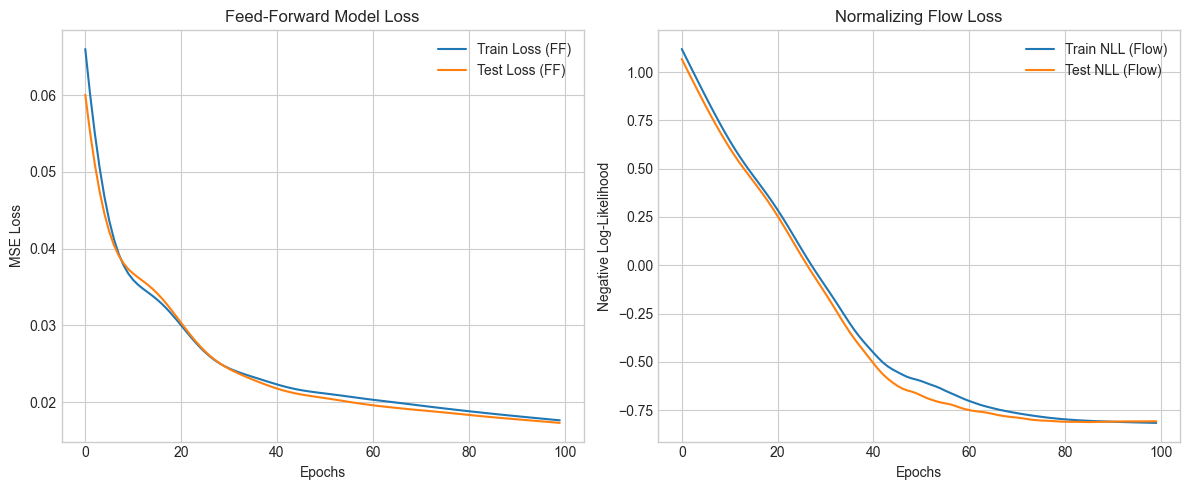

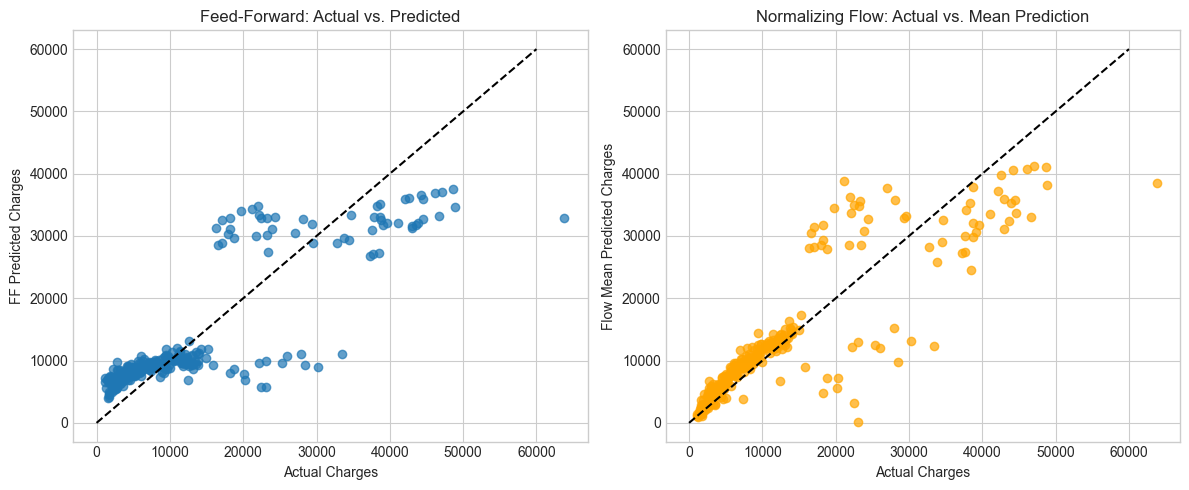

In [5]:
#############################################
# 5) Visualizations
#############################################

# 5a. Plot training and test loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses_ff, label="Train Loss (FF)")
plt.plot(val_losses_ff, label="Test Loss (FF)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Feed-Forward Model Loss")

plt.subplot(1,2,2)
plt.plot(losses_flow, label="Train NLL (Flow)")
plt.plot(val_losses_flow, label="Test NLL (Flow)")
plt.xlabel("Epochs")
plt.ylabel("Negative Log-Likelihood")
plt.legend()
plt.title("Normalizing Flow Loss")
plt.tight_layout()
plt.show()

# 5b. Scatter plots: Actual vs. Predicted for both models
with torch.no_grad():
    ff_model.eval()
    y_ff_pred = ff_model(X_test)
    # Un-scale predictions and targets
    y_ff_pred_unscaled = y_ff_pred * 50000.0
    y_test_unscaled = y_test * 50000.0

    # Flow model: estimate mean predictions from samples
    num_samples = 100
    flow_preds = []
    for i in range(X_test.shape[0]):
        x_i = X_test[i].unsqueeze(0)
        z_samples = torch.randn(num_samples, 1)
        x_repeated = x_i.repeat(num_samples, 1)
        y_samples = flow_model.inverse(z_samples.squeeze(-1), x_repeated)
        flow_preds.append(y_samples.mean().item())
    flow_preds = torch.tensor(flow_preds, dtype=torch.float32)
    flow_preds_unscaled = flow_preds * 50000.0

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test_unscaled.numpy(), y_ff_pred_unscaled.numpy(), alpha=0.7)
plt.plot([0, 60000], [0, 60000], 'k--')
plt.xlabel("Actual Charges")
plt.ylabel("FF Predicted Charges")
plt.title("Feed-Forward: Actual vs. Predicted")

plt.subplot(1,2,2)
plt.scatter(y_test_unscaled.numpy(), flow_preds_unscaled.numpy(), alpha=0.7, color='orange')
plt.plot([0, 60000], [0, 60000], 'k--')
plt.xlabel("Actual Charges")
plt.ylabel("Flow Mean Predicted Charges")
plt.title("Normalizing Flow: Actual vs. Mean Prediction")
plt.tight_layout()
plt.show()





In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# inside or right after your torch.no_grad() block:
# move to CPU and convert to numpy arrays
y_ff_vals   = y_ff_pred_unscaled.detach().cpu().numpy()
y_true_vals = y_test_unscaled.detach().cpu().numpy()
y_flow_vals = flow_preds_unscaled.detach().cpu().numpy()




print("FF  MSE:",  mean_squared_error(y_true_vals, y_ff_vals))
print("Flow MSE:", mean_squared_error(y_true_vals, y_flow_vals))
print("FF  MAE:",  mean_absolute_error(y_true_vals, y_ff_vals))
print("Flow MAE:", mean_absolute_error(y_true_vals, y_flow_vals))


FF  MSE: 43292320.0
Flow MSE: 35818984.0
FF  MAE: 4857.4414
Flow MAE: 3786.031


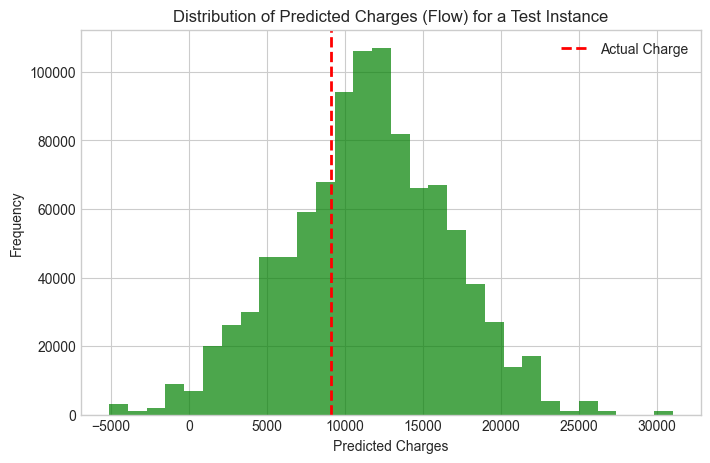

In [ ]:
# 5c. Plot distribution of predictions from the flow for a single test sample
# Choose an example from the test set (e.g., first instance)
with torch.no_grad():
    x_example = X_test[0].unsqueeze(0)
    actual_charge = (y_test[0] * 50000.0).item()
    num_dist_samples = 1000
    z_dist_samples = torch.randn(num_dist_samples, 1)
    x_example_repeated = x_example.repeat(num_dist_samples, 1)
    y_dist_samples = flow_model.inverse(z_dist_samples.squeeze(-1), x_example_repeated)
    # Flatten the output to ensure it's 1D
    y_dist_samples_unscaled = (y_dist_samples * 50000.0).squeeze().flatten().numpy()

plt.figure(figsize=(8,5))
plt.hist(y_dist_samples_unscaled, bins=30, alpha=0.7, color='green')
plt.axvline(actual_charge, color='red', linestyle='dashed', linewidth=2, label="Actual Charge")
plt.xlabel("Predicted Charges")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Charges (Flow) for a Test Instance")
plt.legend()
plt.show()


100%|██████████| 268/268 [12:27<00:00,  2.79s/it]


Average CRPS: 6123.928111678008


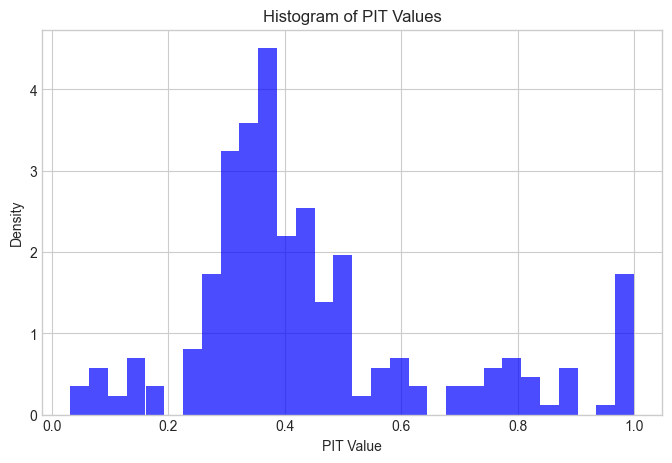

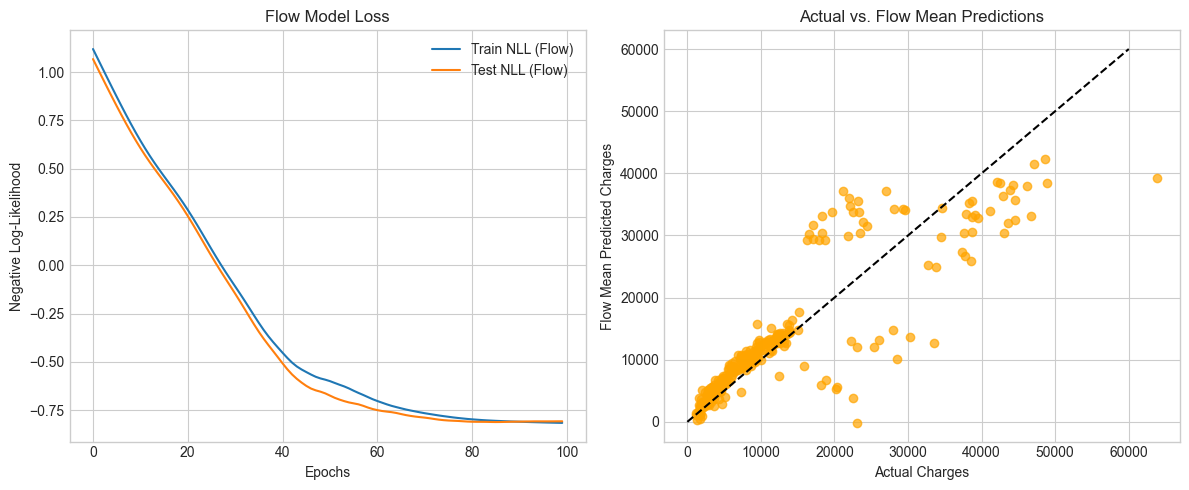

In [10]:
from tqdm import tqdm

#############################################
# 4) Additional Distribution Metrics: PIT and CRPS
#############################################

def compute_distribution_metrics(flow_model, X_test, y_test, num_samples=1000):
    """
    Compute the PIT values and CRPS for each test sample.
    - PIT: the fraction of predicted samples below the actual target.
    - CRPS: computed as mean(|samples - y_true|) - 0.5 * mean(|samples_i - samples_j|).
    Returns two lists: one for PIT values and one for CRPS values.
    """
    pit_values = []
    crps_values = []
    for i in tqdm(range(X_test.shape[0])):
        x_i = X_test[i].unsqueeze(0)  # [1, features]
        # Sample from the predictive distribution
        z_samples = torch.randn(num_samples, 1)
        x_repeated = x_i.repeat(num_samples, 1)
        with torch.no_grad():
            y_samples = flow_model.inverse(z_samples.squeeze(-1), x_repeated)
        # Un-scale predictions
        y_samples_unscaled = (y_samples * 50000.0).squeeze()
        # Get true value (un-scaled)
        y_true = (y_test[i] * 50000.0).item()
        
        # Compute PIT: fraction of samples below the true value
        pit = (y_samples_unscaled < y_true).float().mean().item()
        pit_values.append(pit)
        
        # Compute CRPS:
        # CRPS = mean(|y_samples - y_true|) - 0.5 * mean(|y_samples_i - y_samples_j|)
        abs_errors = torch.abs(y_samples_unscaled - y_true)
        term1 = abs_errors.mean().item()
        # Compute pairwise absolute differences in a vectorized way
        diff = torch.abs(y_samples_unscaled.unsqueeze(0) - y_samples_unscaled.unsqueeze(1))
        term2 = 0.5 * diff.mean().item()
        crps = term1 - term2
        crps_values.append(crps)
    return pit_values, crps_values

pit_vals, crps_vals = compute_distribution_metrics(flow_model, X_test, y_test, num_samples=1000)
avg_crps = np.mean(crps_vals)
print("Average CRPS:", avg_crps)

# Plot PIT histogram
plt.figure(figsize=(8,5))
plt.hist(pit_vals, bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel("PIT Value")
plt.ylabel("Density")
plt.title("Histogram of PIT Values")
plt.show()

#############################################
# 5) Other Visualizations (Loss Curves and Scatter Plots)
#############################################

# Loss curves for the flow model
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses_flow, label="Train NLL (Flow)")
plt.plot(val_losses_flow, label="Test NLL (Flow)")
plt.xlabel("Epochs")
plt.ylabel("Negative Log-Likelihood")
plt.legend()
plt.title("Flow Model Loss")

# For scatter plots, let's obtain the mean predictions from the flow
num_samples = 100
flow_mean_preds = []
for i in range(X_test.shape[0]):
    x_i = X_test[i].unsqueeze(0)
    z_samples = torch.randn(num_samples, 1)
    x_repeated = x_i.repeat(num_samples, 1)
    with torch.no_grad():
        y_samples = flow_model.inverse(z_samples.squeeze(-1), x_repeated)
    flow_mean_preds.append(y_samples.mean().item())
flow_mean_preds = torch.tensor(flow_mean_preds, dtype=torch.float32)
flow_mean_preds_unscaled = flow_mean_preds * 50000.0
y_test_unscaled = y_test * 50000.0

plt.subplot(1,2,2)
plt.scatter(y_test_unscaled.numpy(), flow_mean_preds_unscaled.numpy(), alpha=0.7, color='orange')
plt.plot([0, 60000], [0, 60000], 'k--')
plt.xlabel("Actual Charges")
plt.ylabel("Flow Mean Predicted Charges")
plt.title("Actual vs. Flow Mean Predictions")
plt.tight_layout()
plt.show()




Quantile Levels (percent): [90, 92, 94, 96, 99]
Predicted Quantiles: [33697.93789063 36440.63265625 39191.05398438 42300.993125
 50424.47164062]
Empirical Quantiles: [35451.54960938 38429.2325     39547.8728125  43174.01078125
 47589.48027344]
Tail Absolute Error (TAE): [1753.61171875 1988.59984375  356.81882812  873.01765625 2834.99136718]
Tail Relative Error (TRE): [0.04946502 0.05174706 0.00902245 0.02022091 0.05957181]


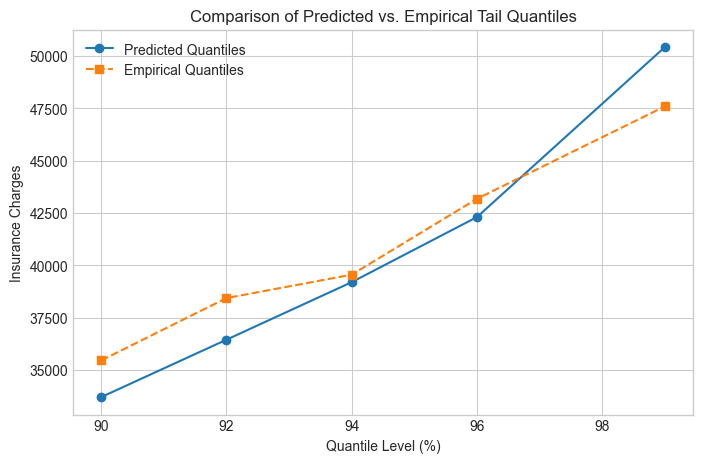

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_samples = 100  # number of samples per test instance for quantile estimation
q_levels = [90, 92, 94, 96, 99]  # tail quantiles (percentile levels)

# Collect predicted samples for all test instances
all_samples = []  # will become a list of numpy arrays for each instance

flow_model.eval()  # ensure the model is in evaluation mode

for i in range(X_test.shape[0]):
    x_i = X_test[i].unsqueeze(0)  # shape [1, feature_dim]
    # Sample from the base Gaussian distribution for this instance
    z_samples = torch.randn(num_samples, 1)
    # Repeat the conditioning input for each sample
    x_repeated = x_i.repeat(num_samples, 1)
    with torch.no_grad():
        # Generate predicted samples (in normalized scale)
        y_samples = flow_model.inverse(z_samples.squeeze(-1), x_repeated)
    # Convert predictions to original scale: multiply by 50000
    y_samples_orig = (y_samples * 50000.0).cpu().numpy()
    all_samples.append(y_samples_orig)

# Flatten the array of predicted samples so that we have one large predicted sample set
all_samples_flat = np.concatenate(all_samples, axis=0)  # shape: (n_test * num_samples,)

# Compute predicted quantiles from the flow's overall samples
predicted_quantiles = np.percentile(all_samples_flat, q_levels)

# Compute the empirical quantiles from the test set target values (denormalized)
y_test_orig = (y_test * 50000.0).cpu().numpy().flatten()
empirical_quantiles = np.percentile(y_test_orig, q_levels)

# Compute Tail Absolute Error (TAE) and Tail Relative Error (TRE) for each quantile level
TAE = np.abs(predicted_quantiles - empirical_quantiles)
TRE = TAE / empirical_quantiles

# Print the computed metrics
print("Quantile Levels (percent):", q_levels)
print("Predicted Quantiles:", predicted_quantiles)
print("Empirical Quantiles:", empirical_quantiles)
print("Tail Absolute Error (TAE):", TAE)
print("Tail Relative Error (TRE):", TRE)

# Visualize the predicted vs. empirical quantiles
plt.figure(figsize=(8,5))
plt.plot(q_levels, predicted_quantiles, 'o-', label="Predicted Quantiles")
plt.plot(q_levels, empirical_quantiles, 's--', label="Empirical Quantiles")
plt.xlabel("Quantile Level (%)")
plt.ylabel("Insurance Charges")
plt.title("Comparison of Predicted vs. Empirical Tail Quantiles")
plt.legend()
plt.show()
